# Pytorch-super resolution Demo

In [1]:
# Load the package you are going to use
import torch
from torch.autograd import Variable
from PIL import Image
import numpy as np
import time, math
import matplotlib.pyplot as plt
import platform
import os
from models.SRCNN.model import SRCNN
from models.FSRCNN.model import FSRCNN
from models.VDSR.model import VDSR
from models.ESPCN.model import ESPCN
from models.DRRN.model import DRRN
from models.ESPCN.model import ESPCN
from models.DRCN.model import DRCN
from models.LapSRN.model import LapSRN
import cv2
from tqdm import tqdm

%matplotlib inline
import h5py
import math
import copy

# import matlab.engine
# eng = matlab.engine.start_matlab()
# eng.addpath('./quant_eval')
# eng.addpath('./quant_eval/ifcvec_release')

In [2]:
# detect device
use_cuda = True
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [3]:
def get_platform_path():
    system = platform.system()
    data_dir, model_dir, checkpoint_dir, dirs = '', '', '', []
    if system == 'Windows':
        drive, common_dir = 'F', 'cache'
        data_dir = '{}:/{}/data'.format(drive, common_dir)
        model_dir = '{}:/{}/model'.format(drive, common_dir)
        checkpoint_dir = '{}:/{}/checkpoint'.format(drive, common_dir)
        dirs = [data_dir, model_dir, checkpoint_dir]

    elif system == 'Linux':
        common_dir = '/data'
        data_dir = '{}/data'.format(common_dir)
        model_dir = '{}/model'.format(common_dir)
        checkpoint_dir = '{}/checkpoint'.format(common_dir)
        dirs = [data_dir, model_dir, checkpoint_dir]

    for dir in dirs:
        if not os.path.exists(dir):
            os.mkdir(dir)

    return data_dir, model_dir, checkpoint_dir


In [4]:
# data/models/checkpoint in different platform
data_dir, model_dir, checkpoint_dir = get_platform_path()

  - This model is trained on [291](https://drive.google.com/open?id=1Rt3asDLuMgLuJvPA1YrhyjWhb97Ly742) images with data augmentation
  - No bias is used in this implementation, and the gradient clipping's implementation is different from paper

In [5]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
# im_gt = Image.open("D:\jupyter\pytorch-vdsr\Set5/butterfly_GT.bmp").convert("RGB")
# im_b = Image.open("D:\jupyter\pytorch-vdsr\Set5/butterfly_GT_scale_3.bmp").convert("RGB")

file_gt = "F:\cache\data\Set5_SR\image_SRF_4\img_001_SRF_4_HR.png"
file_b = "F:\cache\data\Set5_SR\image_SRF_4\img_001_SRF_4_bicubic.png"

im_gt = Image.open(file_gt).convert("RGB")
im_b = Image.open(file_b).convert("RGB")

# file = h5py.File("D:\jupyter\SRCNN-pytorch\\Set5_x3.h5", 'r')
# im_gt_y = np.array(file['hr'][str(2)]).astype(float)
# im_b_y = np.array(file['lr'][str(2)]).astype(float)

# im_b = im_b.resize((250, 360), Image.BICUBIC)

In [6]:
# ITU-R BT.601
# https://en.wikipedia.org/wiki/YCbCr
# RGB -> YCbCr

# def rgb2ycbcr(rgb):
#     m = np.array([[ 65.481, 128.553, 24.966],
#                   [-37.797, -74.203, 112],
#                   [ 112, -93.786, -18.214]])
#     shape = rgb.shape
#     if len(shape) == 3:
#         rgb = rgb.reshape((shape[0] * shape[1], 3))
#     ycbcr = np.dot(rgb, m.transpose() / 255.)
#     ycbcr[:,0] += 16.
#     ycbcr[:,1:] += 128.
#     return ycbcr.reshape(shape)

# ITU-R BT.601
# https://en.wikipedia.org/wiki/YCbCr
# YUV -> RGB
# def ycbcr2rgb(ycbcr):
#     m = np.array([[ 65.481, 128.553, 24.966],
#                   [-37.797, -74.203, 112],
#                   [ 112, -93.786, -18.214]])
#     shape = ycbcr.shape
#     if len(shape) == 3:
#         ycbcr = ycbcr.reshape((shape[0] * shape[1], 3))
#     rgb = copy.deepcopy(ycbcr)
#     rgb[:,0] -= 16.
#     rgb[:,1:] -= 128.
#     rgb = np.dot(rgb, np.linalg.inv(m.transpose()) * 255.)
#     return rgb.clip(0, 255).reshape(shape)

In [7]:
# / 255
OrigT = np.array(
    [[ 65.481, 128.553, 24.966 ],
     [-37.797, -74.203, 112.0  ],
     [  112.0, -93.786, -18.214]])

OrigOffset = np.array([16, 128, 128])

# OrigT_inv = np.array([[0.00456621,  0.,  0.00625893],
#           [0.00456621, -0.00153632, -0.00318811],
#           [0.00456621,  0.00791071,  0.]])
OrigT_inv = np.linalg.inv(OrigT)


def rgb2ycbcr(rgb_img):
    if rgb_img.shape[2] == 1:
        return rgb_img
    if rgb_img.dtype == float:
        T = 1.0 / 255.0
        offset = 1 / 255.0
    elif rgb_img.dtype == np.uint8:
        T = 1.0 / 255.0
        offset = 1.0 
    elif rgb_img.dtype == np.uint16:
        T = 257.0 / 65535.0
        offset = 257.0
    else:
        raise Exception('the dtype of image does not support')
    T = T * OrigT
    offset = offset * OrigOffset
    ycbcr_img = np.zeros(rgb_img.shape, dtype=float)
    for p in range(rgb_img.shape[2]):
        ycbcr_img[:, :, p] = T[p, 0] * rgb_img[:, :, 0] + T[p, 1] * rgb_img[:, :, 1] + T[p, 2] * rgb_img[:, :, 2] + offset[p]
    return np.array(ycbcr_img, dtype=rgb_img.dtype)

def ycbcr2rgb(ycbcr_img):
    
    if ycbcr_img.shape[2] == 1:
        return ycbcr_img
    if ycbcr_img.dtype == float:
        T = 255.0
        offset = 1.0
    elif ycbcr_img.dtype == np.uint8:
        T = 255.0
        offset = 255.0
    elif ycbcr_img.dtype == np.uint16:
        T = 65535.0 / 257.0
        offset = 65535.0
    else:
        raise Exception('the dtype of image does not support')
    T = T * OrigT_inv
    offset = offset * np.matmul(OrigT_inv, OrigOffset)
    rgb_img = np.zeros(ycbcr_img.shape, dtype=float)
    for p in range(rgb_img.shape[2]):
        rgb_img[:, :, p] =  T[p, 0] * ycbcr_img[:, :, 0] + T[p, 1] * ycbcr_img[:, :, 1] + T[p, 2] * ycbcr_img[:, :, 2] - offset[p]
    return np.array(rgb_img.clip(0, 255), dtype=ycbcr_img.dtype)

In [8]:
# Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
im_gt_ycbcr = rgb2ycbcr(np.array(im_gt))
im_b_ycbcr = rgb2ycbcr(np.array(im_b))
# im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
# im_b_ycbcr = np.array(im_b.convert("YCbCr"))
im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
im_b_y = im_b_ycbcr[:,:,0].astype(float)

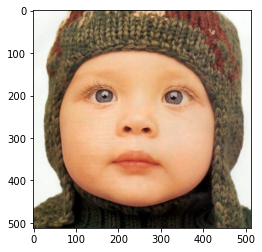

In [9]:
# test reverse function
im_b_rgb = ycbcr2rgb(im_gt_ycbcr)
plt.imshow(np.array(im_b_rgb, dtype=np.uint8))

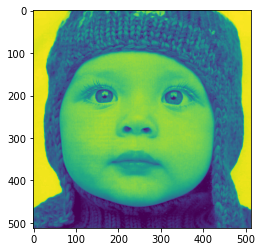

In [10]:
plt.imshow(im_gt_y)

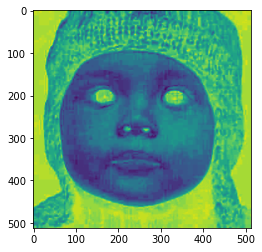

In [11]:
plt.imshow(im_gt_ycbcr[:,:,1].astype(float))

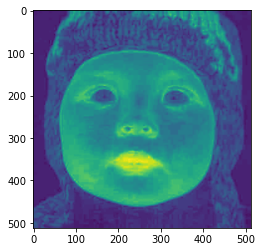

In [12]:
plt.imshow(im_gt_ycbcr[:,:,2].astype(float))

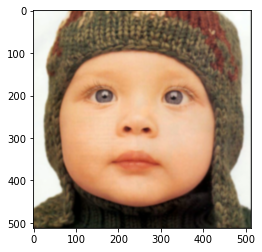

In [13]:
blurImg = cv2.GaussianBlur(im_b_rgb,(11,11),1.5, borderType=cv2.BORDER_ISOLATED)
plt.imshow(blurImg)

In [14]:
# Here is the funtion for shaving the edge of image
def shave(pred, gt, shave_border):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    return pred, gt

In [15]:
# Here is the function for PSNR calculation
def PSNR(pred, gt):
    imdff = pred - gt
    rmse = np.mean(np.mean(imdff ** 2, axis=1), axis=0)
    if rmse == 0:
        return 100
    return 10 * math.log10(255 * 255 / rmse)

In [16]:
# Here is the function for SSIM calculation
def SSIM_index(pred, gt):
    height, width = pred.shape[:2]
    kernel_size = 11
    padding = kernel_size // 2
    std = 1.5
    if height < kernel_size or width < kernel_size:
        return float('-inf')
    K = [0.01, 0.03]
    L = 255
    C1, C2 = (K[0] * L) ** 2, (K[1] * L) ** 2
    pred, gt = np.array(pred, dtype=float), np.array(gt, dtype=float)
    mu1 = cv2.GaussianBlur(pred,(kernel_size, kernel_size), std, borderType=None)
    mu2 = cv2.GaussianBlur(gt,(kernel_size, kernel_size), std, borderType=None)
    mu1, mu2 = shave(mu1, mu2, padding)
    
    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.GaussianBlur(pred * pred, (kernel_size, kernel_size), std, borderType=None)
    sigma2_sq = cv2.GaussianBlur(gt * gt, (kernel_size, kernel_size), std, borderType=None)
    sigma1_sq, sigma2_sq = shave(sigma1_sq, sigma2_sq, padding)
    sigma1_sq, sigma2_sq = sigma1_sq - mu1_sq, sigma2_sq - mu2_sq
    sigma12 = cv2.GaussianBlur(pred * gt, (kernel_size, kernel_size), std, borderType=None)
    sigma12, _ = shave(sigma12, sigma12, padding)
    sigma12 = sigma12 - mu1_mu2
    if C1 > 0 and C2 > 0:
        ssim_map = ((2*mu1_mu2 + C1) * (2*sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    else:
        pass
    mssim = np.mean(ssim_map)
    return mssim, ssim_map

In [17]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = ycbcr2rgb(img)
    return img

In [18]:
def avg_PSNR(num, dataset, use_bicubic = True, model = None, use_matlab=False, upscaleFactor = 3, save = False, output_name = ""):
        
    total_psnr = 0
    total_ssim = 0
    for i in tqdm(range(1, 1 + num)):
        if i <= 9:
            index = '00' + str(i)
        elif i <= 99:
            index = '0' + str(i)
        else:
            index = str(i)
        file_b = "F:\cache\data\{}\image_SRF_{}\img_{}_SRF_{}_LR.png".format(dataset, upscaleFactor, index, upscaleFactor)
        file_gt = "F:\cache\data\{}\image_SRF_{}\img_{}_SRF_{}_HR.png".format(dataset, upscaleFactor, index, upscaleFactor)
        
        im_b = Image.open(file_b)
        im_gt = Image.open(file_gt)
        
        if len(im_b.split()) == 3:
            
            if use_bicubic:
                im_b = im_b.resize(im_gt.size, Image.BICUBIC)

            im_gt_ycbcr = rgb2ycbcr(np.array(im_gt))
            im_b_ycbcr = rgb2ycbcr(np.array(im_b))

            im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
        
        else:
            
            if use_bicubic:
                im_b = im_b.resize(im_gt.size, Image.BICUBIC)
            
            im_gt_y = np.array(im_gt, dtype=float)
            im_b_y = np.array(im_b, dtype=float)
        
        if model == None:
            im_b_y_shave, im_gt_y_shave = shave(im_b_y, im_gt_y, upscaleFactor)
            psnr = PSNR(im_b_y_shave, im_gt_y_shave)
            ssim, _ = SSIM_index(im_b_y_shave, im_gt_y_shave)
            
#             res = eng.compute_difference(eng.imread(file_b), eng.imread(file_gt), upscaleFactor)

            im_h_y = im_b_y
    
        else:
            # ========================== test ==================================
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).\
                view(1, -1, im_input.shape[0], im_input.shape[1]).cuda()
            
            model = model.cuda()
            
            with torch.no_grad():
                out = model(im_input)
            out = out.cpu()
            im_h_y = out.data[0].clamp(0,1).numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]
            
            # ========================== test ==================================
            
            im_b_y_shave, im_gt_y_shave = shave(im_h_y, im_gt_y, upscaleFactor)
            psnr = PSNR(im_b_y_shave, im_gt_y_shave)
            ssim, _ = SSIM_index(im_b_y_shave, im_gt_y_shave)
            
        if save:
            
            if not use_bicubic and len(im_b.split()) == 3:
                im_b = im_b.resize(im_gt.size, Image.BICUBIC)
                im_b_ycbcr = rgb2ycbcr(np.array(im_b))
                
            if len(im_b.split()) == 3:
                im_b_rgb = colorize(im_h_y, im_b_ycbcr)
            else:
                im_b_rgb = im_h_y
            
            im_b_rgb[im_b_rgb < 0] = 0
            im_b_rgb[im_b_rgb > 255.] = 255.
            
            img_save = Image.fromarray(im_b_rgb).convert("RGB")
            img_save.save(file_b.replace("LR", output_name))
            
        total_psnr += psnr
        total_ssim += ssim
        
    return total_psnr / num, total_ssim / num

In [70]:
# Load the pretrained model
model = VDSR(num_channels=1,num_residuals=20)
# model = SRCNN(num_channels=1, filter=64)
# model = FSRCNN(num_channels=1, upscale_factor=2)
# model = ESPCN(num_channels=1, upscale_factor=3)
# model = DRRN(num_channels=1)
# model = ESPCN(num_channels=1, upscale_factor=3)
# model = DRCN(num_channels=1, num_recursions=16)
# model = LapSRN(num_channles=1)

checkpoint = torch.load('F:\\cache\\checkpoint\\VDSR-(2, 3, 4)x_10.pth')
#checkpoint = torch.load('F:\\cache\\model\\VDSR.pth')

from collections import OrderedDict
new_state_dict = OrderedDict()
for key, value in checkpoint['net'].items():
    key = key.replace('module.', '')
    new_state_dict[key] = value
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [71]:
upscaleFactor = 2
use_bicubic = True
output_name = "VDSR"
save = False

In [72]:
avg_PSNR(5, 'Set5_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor, output_name=output_name, save=save)

100%|██████████| 5/5 [00:00<00:00, 22.01it/s]


(16.81164182880564, 0.5052651208405761)

In [45]:
avg_PSNR(14, 'Set14_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor, output_name=output_name, save=save)

100%|██████████| 14/14 [00:01<00:00, 10.99it/s]


(32.844515669474454, 0.9110228585159634)

In [41]:
avg_PSNR(100, 'BSD100_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor, output_name=output_name, save=save)

100%|██████████| 100/100 [00:07<00:00, 13.30it/s]


(31.57162993066489, 0.8892851166484372)

In [39]:
avg_PSNR(100, 'Urban100_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor, output_name=output_name, save=save)

100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


(25.14590260067078, 0.7504359318539836)

In [ ]:
avg_PSNR(100, 'Manga109_SR', use_bicubic=use_bicubic, model=model, upscaleFactor=upscaleFactor, output_name=output_name, save=save)

  9%|▉         | 9/100 [01:04<11:00,  7.26s/it]

In [26]:
# Calculate the PNSR for bicubic interpolation
# For best PSNR score, you will have to use Matlab for color space transformation, 
# since it is different from Python's implementation
psnr_bicubic = PSNR(im_gt_y, im_b_y)
print('psnr for bicubic is {}dB'.format(psnr_bicubic))

psnr for bicubic is 31.824112951196458dB


In [27]:
# Prepare for the input, a pytorch tensor
im_input = im_b_y/255.
im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])

In [28]:
# Let's try the network feedforward in cpu mode
model = model.cpu()

In [29]:
# Let's see how long does it take for processing
start_time = time.time()
out = model(im_input)
elapsed_time = time.time() - start_time
print("It takes {}s for processing in cpu mode".format(elapsed_time))

It takes 1.5445992946624756s for processing in cpu mode


In [30]:
# Now let's try the network feedforward in gpu mode
model = model.cuda()
im_input = im_input.cuda()

In [31]:
# Let's see how long does it take for processing in gpu mode
model = model
start_time = time.time()
out = model(im_input)
elapsed_time = time.time() - start_time
print("It takes {}s for processing in gpu mode".format(elapsed_time))

It takes 0.11369585990905762s for processing in gpu mode


In [32]:
# Get the output image
out = out.cpu()
im_h_y = out.data[0].numpy().astype(np.float32)
im_h_y = im_h_y * 255.
im_h_y[im_h_y < 0] = 0
im_h_y[im_h_y > 255.] = 255.
im_h_y = im_h_y[0,:,:]

In [33]:
# Calculate the PNSR for vdsr prediction
psnr_predicted = PSNR(im_gt_y, im_h_y)
print('psnr for SR is {}dB'.format(psnr_predicted))

psnr for SR is 33.26334230397838dB


In [34]:
# Calculate the PNSR different between bicubic interpolation and vdsr prediction
print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))

PSNR improvement is 1.4392293527819255dB


In [35]:
# Colorize the grey-level image and convert into RGB mode
im_h = colorize(im_h_y, im_b_ycbcr)
im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")

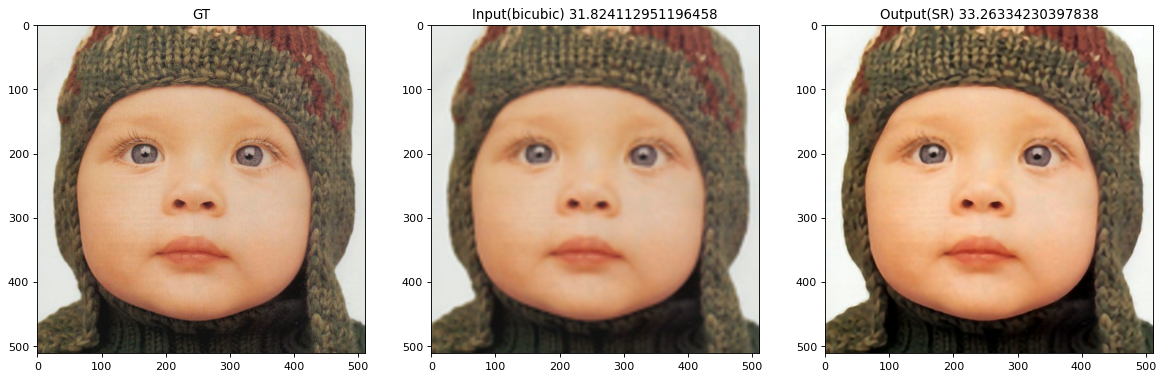

In [36]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(im_gt)
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(im_b)
ax.set_title("Input(bicubic) {}".format(psnr_bicubic))

ax = plt.subplot("133")
ax.imshow(im_h)
ax.set_title("Output(SR) {}".format(psnr_predicted))
plt.show()